In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2

In [ ]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf

# Load And Prepare Data

In [ ]:
# get data

!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
file_dir = '/content/nyu_depth_v2_labeled.mat'

# or
# file_dir = <data on drive>

--2022-01-30 20:20:11--  http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2972037809 (2.8G)
Saving to: ‘nyu_depth_v2_labeled.mat’

nyu_depth_v2_labele 100%[===================>]   2.77G  7.87MB/s    in 3m 46s  

2022-01-30 20:23:57 (12.5 MB/s) - ‘nyu_depth_v2_labeled.mat’ saved [2972037809/2972037809]



In [ ]:
def cellarray2list(file, cellName):
  List = []
  for string in file[cellName][0]:
    List.append(''.join(map(chr, file[string][:])))
  return List

In [ ]:
# read data
f = h5py.File(file_dir,'r')

depths = np.moveaxis(f['depths'], [1,2], [2,1])
images = np.moveaxis(f['images'], [1,2,3], [3,2,1])
instances = np.moveaxis(f['instances'], [1,2], [2,1])
labels = np.moveaxis(f['labels'], [1,2], [2,1])
names = cellarray2list(f, 'names')
names = ['unlabeled'] + names

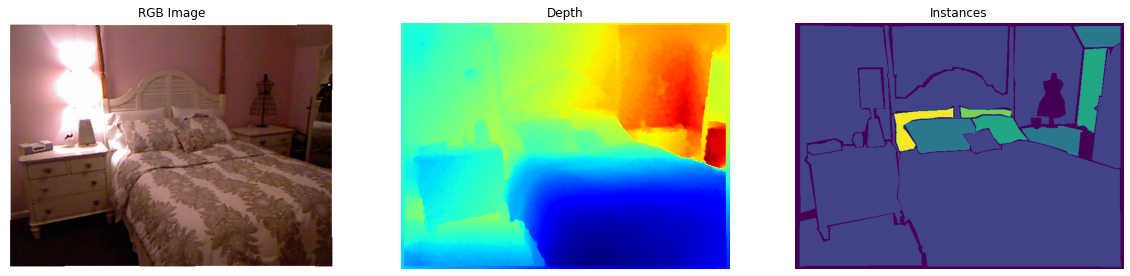

In [ ]:
i = np.random.randint(len(images))
 
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(images[i])
plt.title('RGB Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(depths[i], cmap='jet')
plt.title('Depth')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(instances[i])
plt.title('Instances')
plt.axis('off')

plt.show()

In [ ]:
!mkdir Depth_Data
!mkdir Depth_Data/images Depth_Data/depths

for i in range(len(images)):
  cv2.imwrite('./Depth_Data/images/{}.jpg'.format(i), cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR))
  with open('./Depth_Data/depths/{}.npy'.format(i), 'wb') as f:
    np.save(f, depths[i])

# Creat Model

In [ ]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 50

In [ ]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

In [ ]:
def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  # encoder
  conv1 = downsampling_block(i, 32)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = downsampling_block(pool1, 64)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = downsampling_block(pool2, 128)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = downsampling_block(pool3, 256)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  # bottleneck
  conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

In [ ]:
model = build(HEIGHT, WIDTH, 3)

In [ ]:
model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 240, 320, 32  0           ['conv2d[0][0]']                 
                                )                                                             

# Train Data

In [ ]:
# loading data created in 'Load And Prepare Data' directly
# !git clone https://<your username>:<your token>@github.com/Ar-Rz/Joint-Object-Detection-and-Depth-Estimation-in-Image.git

In [ ]:
N_DATA = 1449

In [ ]:
def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

In [ ]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  # image = image[:, 21:149].astype("float")
  image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  with open(depth_map_path, 'rb') as f:
    depth_map = np.load(f)

  depth_map = imutils.resize(depth_map, height=HEIGHT)
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [ ]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [ ]:
images_paths = ['./Depth_Data/images/{}.jpg'.format(i) for i in range(N_DATA)]
depths_paths = ['./Depth_Data/depths/{}.npy'.format(i) for i in range(N_DATA)]

labels = dict(zip(images_paths, depths_paths))

train_images_paths, valid_images_paths = train_val_split(images_paths, 0.2)
partition = {'train': train_images_paths, 'validation': valid_images_paths}

In [ ]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [ ]:
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)
callbacks = [LearningRateScheduler(poly_decay)]

# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.1

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [ ]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

In [ ]:
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
72/72 [==============================] - 61s 599ms/step - loss: 0.3263 - depth_acc: 0.6204 - val_loss: 0.2077 - val_depth_acc: 0.5616 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - 42s 581ms/step - loss: 0.2008 - depth_acc: 0.6934 - val_loss: 0.2007 - val_depth_acc: 0.6161 - lr: 9.8000e-05
Epoch 3/50
72/72 [==============================] - 45s 627ms/step - loss: 0.1850 - depth_acc: 0.7032 - val_loss: 0.2010 - val_depth_acc: 0.5826 - lr: 9.6000e-05
Epoch 4/50
72/72 [==============================] - 43s 592ms/step - loss: 0.1783 - depth_acc: 0.7081 - val_loss: 0.2016 - val_depth_acc: 0.5415 - lr: 9.4000e-05
Epoch 5/50
72/72 [==============================] - 43s 595ms/step - loss: 0.1745 - depth_acc: 0.7156 - val_loss: 0.2171 - val_depth_acc: 0.4721 - lr: 9.2000e-05
Epoch 6/50
72/72 [==============================] - 43s 593ms/step - loss: 0.1722 - depth_acc: 0.7199 - val_loss: 0.1896 - val_depth_acc: 0.6590 - lr: 9.0000e-05
Epoch 7/50
72/72 [==========

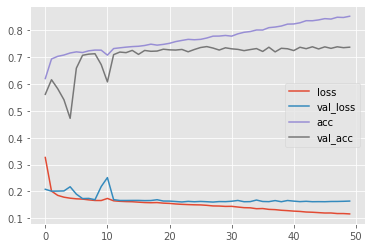

In [ ]:
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [ ]:
x_test = np.empty((len(partition['validation']), HEIGHT, WIDTH, 3))
y_test = np.empty((len(partition['validation']), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['validation'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [ ]:
print(model.evaluate(x_test, y_test))

10/10 [==============================] - 9s 434ms/step - loss: 0.1633 - depth_acc: 0.7351
[0.16330662369728088, 0.7351203560829163]


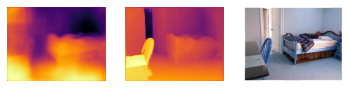

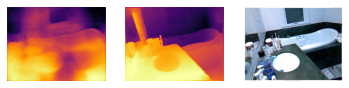

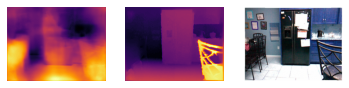

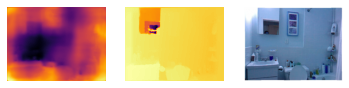

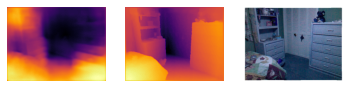

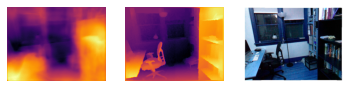

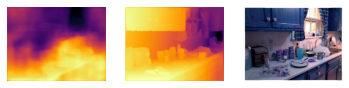

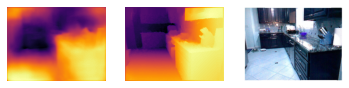

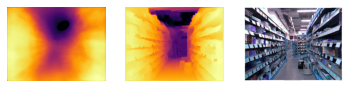

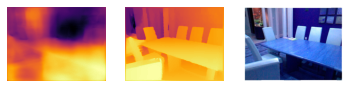

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(10):
  path = partition['validation'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()

# Save Trained Model

In [ ]:
!mkdir Depth_Estimation_Model
model.save('./Depth_Estimation_Model')